# Model topology 02: inspecting model topologies

By Florian Wellmann and Sofia Brisson

In the previous notebook, we generated the topology graph and matrix for the base model. Here, we now inspect what happens when we change the geomodel.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

In [5]:
import sys
sys.path.append('../gempy/')
import gempy as gp
from gempy.assets import topology as tp

No module named 'osgeo'


In [6]:
gp.__file__

'/Users/sofia/opt/anaconda3/envs/gempy/lib/python3.8/site-packages/gempy/__init__.py'

## Initial gempy model

Again, we use the simple model from the previous notebook.

In [7]:
geo_model = gp.create_model('topology_example')
geo_model = gp.init_data(geo_model, extent = [0, 1000, 0, 1000, 0, 1000], resolution = [30,30,30],
                        path_o = 'or_prior_simpler.csv',
                        path_i = 'surf_prior_simpler_2.csv')

gp.map_stack_to_surfaces(geo_model, 
                        {'fault' : ['fault'],
                        'layers' : ['rock1', 'rock2']})

geo_model.set_is_fault(['fault'])

geo_model.surfaces.colors.change_colors({'rock1': '#a1d99b',
                                        'rock2' : '#3182bd',
                                        'basement' : '#d9d9d9'})

interp_data = gp.set_interpolator(geo_model,
                                 compile_theano=True,
                                 theano_optimizer='fast_run', gradient=False,
                                 dype='float32')
gp.compute_model(geo_model)

#gp.plot_2d(geo_model, direction='y')

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                     values
range              1732.05
$C_o$              71428.6
drift equations  [3, 3, 3]



Lithology ids 
  [4. 4. 4. ... 2. 2. 2.] 

We calculate its topology information:

In [8]:
edges_ori, centroids_ori = tp.compute_topology(geo_model)

## Changing the geomodel

For convenience, we first create a function to modify surface and fault points, for an easier generation of a new model:

In [9]:
def modify_geomodel(rock1_left=600, rock1_right=200, rock2_left=800, rock2_right=400, \
    fault_bottom_x=750, fault_top_x=350):
    """Modify and compute geological model for given surface positions
    
    In this highly simplified update function, we only adjust the vertical (z)-position of the surfaces
    and the x-position of the fault points.
    """

    # modifly surface points in vertical direction
    geo_model.modify_surface_points([6,7,8,9], Z=4*[rock1_left])
    geo_model.modify_surface_points([10,11,12,13], Z=4*[rock1_right])
    geo_model.modify_surface_points([14,15,16,17], Z=4*[rock2_left])
    geo_model.modify_surface_points([18,19,20,21], Z=4*[rock2_right])

    # modify fault points in x-direction:
    geo_model.modify_surface_points([0,2,4], X=3*[fault_bottom_x])
    geo_model.modify_surface_points([1,3,5], X=3*[fault_top_x])

    # modify fault orientation value:
    # delete fault orientation
    geo_model.delete_orientations([4])
    # obtain new value from three points
    gp.set_orientation_from_surface_points(geo_model, [0, 1, 2])

    geo_model.update_to_interpolator()

    # compute model
    gp.compute_model(geo_model)
    # gp.plot_2d(geo_model, show_data = False, direction = 'y', cell_number = 10)


A quick example:

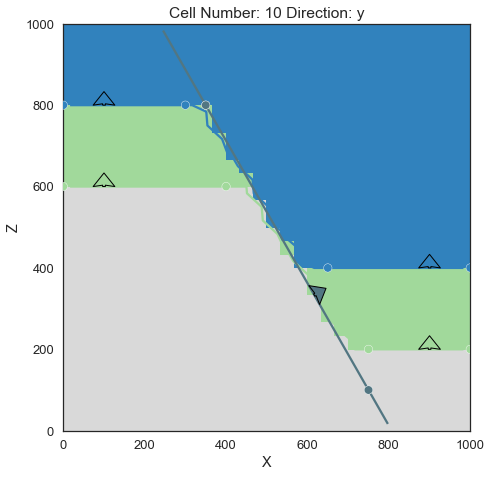

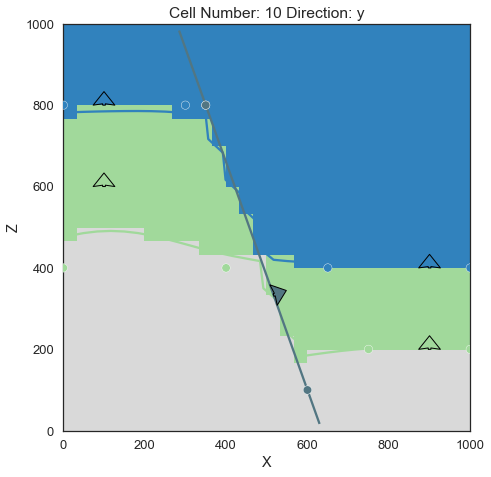

In [10]:
modify_geomodel() # default settings: back to initial model
gp.plot_2d(geo_model, show_data = True, direction = 'y', cell_number = 10, legend=False)
modify_geomodel(rock1_left=400, fault_bottom_x=600)
gp.plot_2d(geo_model, show_data = True, direction = 'y', cell_number = 10, legend=False, show_boundaries=True, show_block=False, show_lith=True)

## Inspecting topologies

Let's now investigate how model topologies change for different geomodels. For this purpose, we first define stochastic variables for the model parameters and then generate a set of realisations:

In [11]:
# set standard derivation as same for all
point_std = 100

# surface points, vertical position
rock1_left_dist = norm(600, point_std)
rock1_right_dist = norm(200, point_std)
rock2_left_dist = norm(800, point_std)
rock2_right_dist = norm(400, point_std)

# fault points, lateral/ x-position:
fault_top_dist = norm(350, point_std)
fault_bottom_dist = norm(750, point_std)

We can then generate random model realizations:

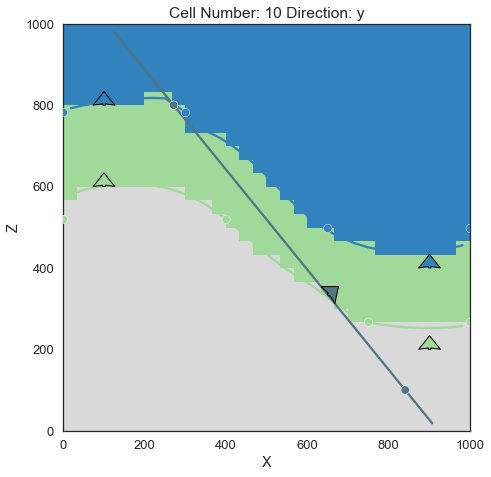

In [12]:
modify_geomodel(rock1_left=rock1_left_dist.rvs(),
                rock1_right=rock1_right_dist.rvs(),
                rock2_left=rock2_left_dist.rvs(),
                rock2_right=rock2_right_dist.rvs(),
                fault_top_x=fault_top_dist.rvs(),
                fault_bottom_x=fault_bottom_dist.rvs()) 

gp.plot_2d(geo_model, show_data = True, direction = 'y', cell_number = 10, legend=False)

If we execute this function a couple of times, we quickly get an impression about the vastly different models that are generated - many of which do not bear a lot of similarity to the original model (note: the effect is here also extreme because of the chosen input point configuration and the large standard deviation).

Here, a quick function to generate a couple of realizations and to plot them in one figure (without the full fancy gempy plotting capabilities, for now):


In [13]:
def plot_realizations(n=16):
    """Create n random realisations and create overview plot
    
    n should be multiple of 4
    """

    fig, ax = plt.subplots(n//4, 4, figsize=(12,12), sharey = True, sharex = True)

    for i in range(n):
        # generate model
        modify_geomodel(rock1_left=rock1_left_dist.rvs(),
                rock1_right=rock1_right_dist.rvs(),
                rock2_left=rock2_left_dist.rvs(),
                rock2_right=rock2_right_dist.rvs(),
                fault_top_x=fault_top_dist.rvs(),
                fault_bottom_x=fault_bottom_dist.rvs()) 
        
        # extract gempy geology blocks
        tmp = geo_model.solutions.block_matrix[1,0,:].reshape(30,30,30) 


        ax[i//4, i%4].imshow(tmp[:,0,::-1].transpose(),cmap = 'tab20c')


Generate some stochastic realizations:

ValueError: cannot reshape array of size 27000 into shape (20,20,20)

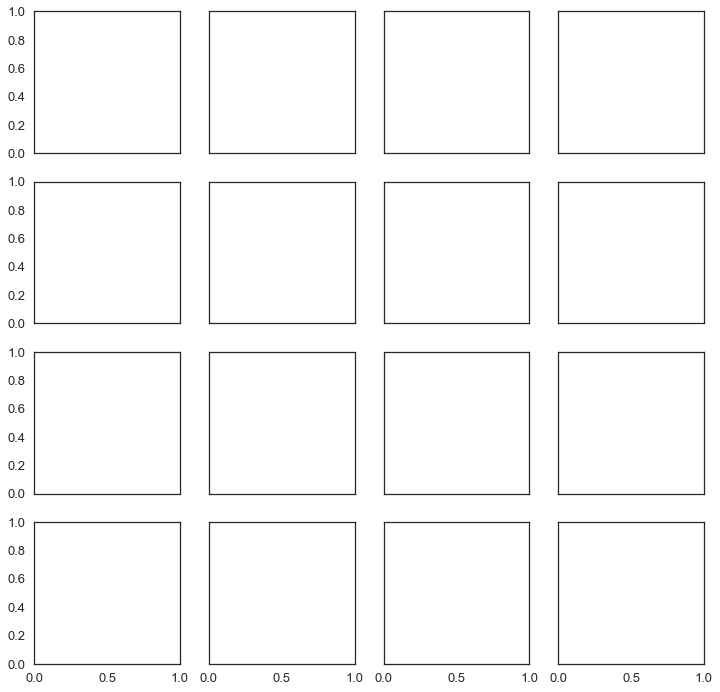

In [14]:
plot_realizations()

Obviously, there are many realizations that don't make any geological sense (or are very far from the original model). Let's see if topology can come to help, here.


Let's now also inspect the corresponding model topologies in graph and matrix view - and for convenience, we directly generate some realizations and create an overview plot:

In [26]:
def plot_realizations_and_topologies(n=6):
    """Create n random realizations and create overview plot of section and topologies"""

    fig, ax = plt.subplots(n, 4, figsize=(14,20))

    # get edges of original model for computation of Jaccard index
    modify_geomodel()
    edges_ori, centroids_ori = tp.compute_topology(geo_model)

    for i in range(2*n):
        # generate model
        modify_geomodel(rock1_left=rock1_left_dist.rvs(),
                rock1_right=rock1_right_dist.rvs(),
                rock2_left=rock2_left_dist.rvs(),
                rock2_right=rock2_right_dist.rvs(),
                fault_top_x=fault_top_dist.rvs(),
                fault_bottom_x=fault_bottom_dist.rvs()) 
        
        # extract gempy geology blocks
        tmp = geo_model.solutions.block_matrix[1,0,:].reshape(80,80,80)

        ax[i % n, 2 * (i // n)].imshow(tmp[:,0,::-1].transpose(), cmap='tab20c')
        
        # compute topology
        edges, centroids = tp.compute_topology(geo_model)

        # compute jaccard index
        j = tp.jaccard_index(edges_ori, edges)
        t = ax[i % n, 2 * (i // n)].text(0.95, 0.95, "J=%.2f" % j, va = 'top', ha = 'right', 
                                         transform=ax[i % n, 2 * (i // n)].transAxes, fontsize=13)
        t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle = 'round'))

        # compute centroid distances
        cent_diff = 0 

        for j in range(1,7):
            cent_diff += np.sqrt(np.sum((centroids_ori[j]-centroids[j])**2))

        t = ax[i % n, 2 * (i // n)].text(0.95, 0.75, "C=%.2f" % cent_diff, va = 'top', ha = 'right', 
                                         transform=ax[i % n, 2 * (i // n)].transAxes, fontsize=13)
        t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle = 'round'))

        # plot topology matrix
        adj_matrix_1 = tp.get_adjacency_matrix(geo_model, edges, centroids).astype(np.int8)

        ax[i % n, 2 * (i // n) + 1].imshow(adj_matrix_1)
        ax[i % n, 2 * (i // n) + 1].set_xticks(np.arange(6))
        ax[i % n, 2 * (i // n) + 1].set_xticklabels(np.arange(1,7))
        ax[i % n, 2 * (i // n) + 1].set_yticks(np.arange(6))
        ax[i % n, 2 * (i // n) + 1].set_yticklabels(np.arange(1,7));

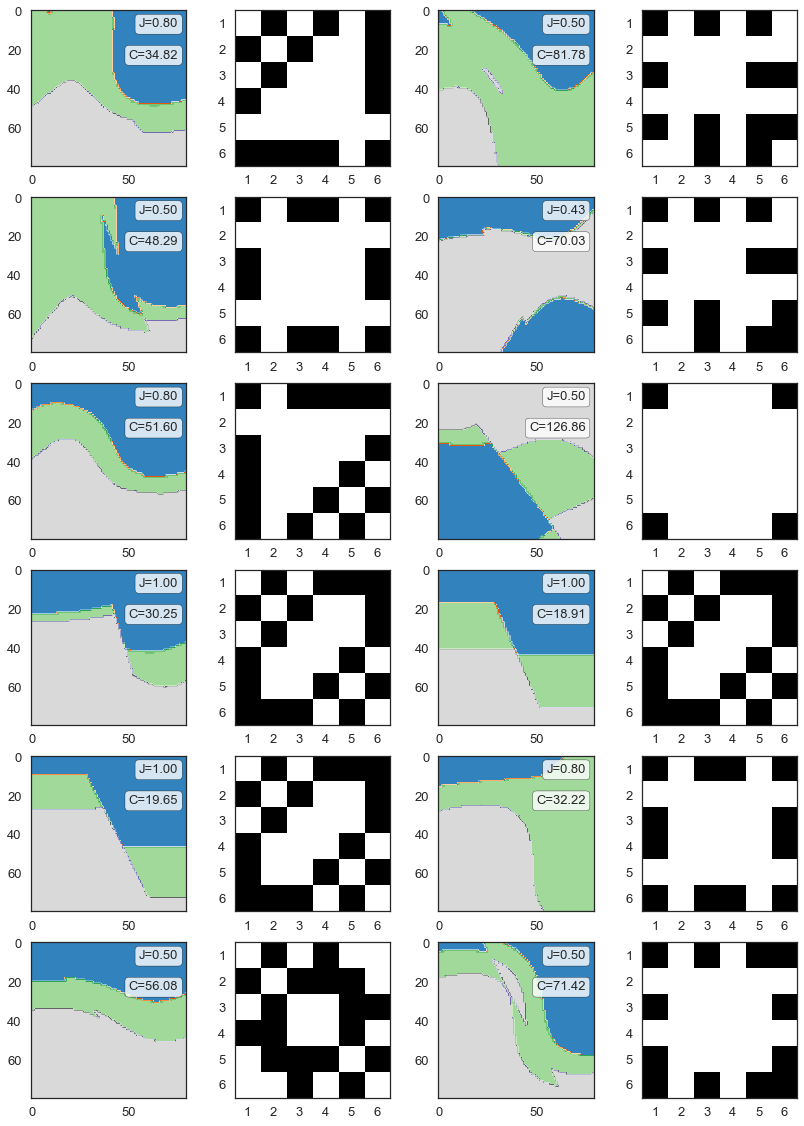

In [27]:
plot_realizations_and_topologies()

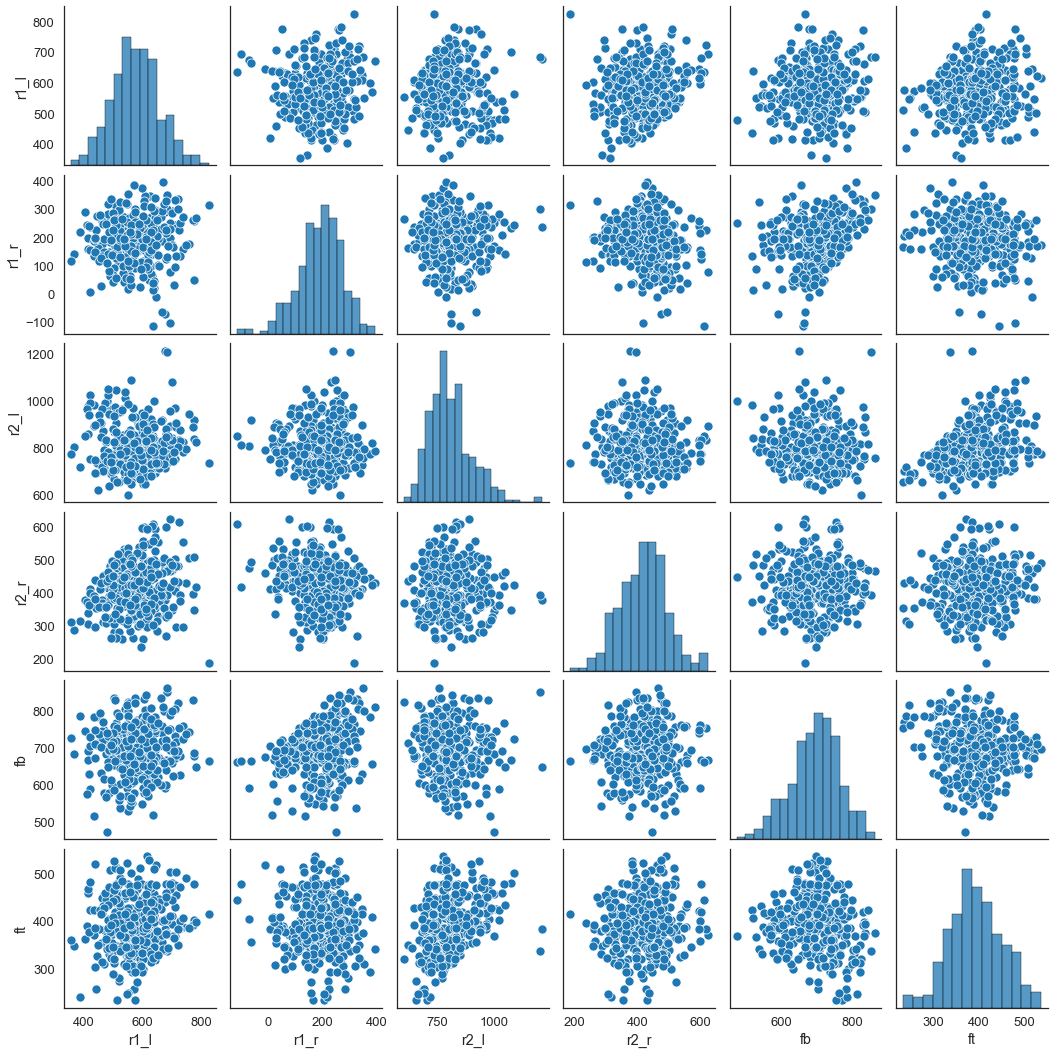

In [62]:
sns.pairplot(accepted_all)

In [64]:
accepted_all['r1_l'].max()

825.9125452262149

In [65]:
np.argmax(accepted_all['r1_l'])

234

In [66]:
accepted_all.iloc[234]

r1_l    825.912545
r1_r    314.919809
r2_l    733.931958
r2_r    184.903930
fb      664.872922
ft      415.701448
Name: 234, dtype: float64

In [75]:
geo_model = gp.create_model('topology_example')
geo_model = gp.init_data(geo_model, extent = [0, 1000, 0, 1000, 0, 1000], resolution = [100,100,100],
                        path_i = 'outlier_model.csv',
                        path_o = 'or_prior_simpler.csv')

gp.map_stack_to_surfaces(geo_model, 
                        {'fault' : ['fault'],
                        'layers' : ['rock1', 'rock2']})

geo_model.set_is_fault(['fault'])

geo_model.surfaces.colors.change_colors({'rock1': '#a1d99b',
                                        'rock2' : '#3182bd',
                                        'basement' : '#d9d9d9'})

interp_data = gp.set_interpolator(geo_model,
                                 compile_theano=True,
                                 theano_optimizer='fast_run', gradient=False,
                                 dype='float32')
gp.compute_model(geo_model)

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                        values
range             1732.050808
$C_o$            71428.571429
drift equations     [3, 3, 3]



Lithology ids 
  [4. 4. 4. ... 2. 2. 2.] 

In [76]:
geo_model.delete_orientations([4])
# obtain new value from three points
gp.set_orientation_from_surface_points(geo_model, [0, 1, 2])
geo_model.update_to_interpolator()

    # compute model
gp.compute_model(geo_model)


Lithology ids 
  [4. 4. 4. ... 2. 2. 2.] 

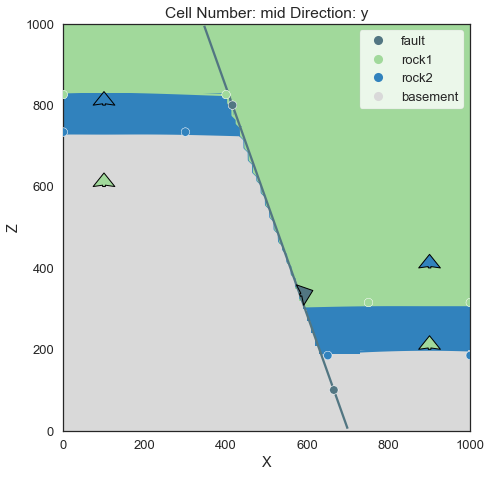

In [77]:
gp.plot_2d(geo_model, direction='y')

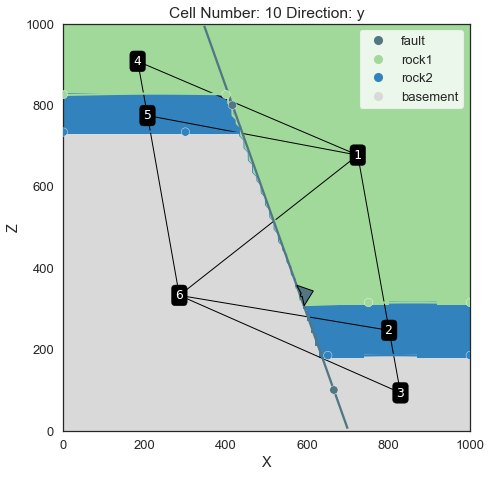

In [78]:
edges_out, centroids_out = tp.compute_topology(geo_model)
gp.plot_2d(geo_model, show_data = True, direction = 'y', cell_number = 10)
gp.plot.plot_topology(geo_model, edges_out, centroids_out, scale=True)
plt.show()